In [27]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as ss
import scipy.optimize as so

csv_path = "./CSV/"

# Exercise 1.1

## 1.1.1

At first we will compute the integral $\langle r \rangle = \int_0^1 r dr = 1/2$, which corresposnds to the average value of the observable $r$ in the interval $[0,1)$. To to this i will generate a large number of pseudo-random rumbers $r$ in the interval $[0,1)$, add them and evaluate their average and its statistical error using the data-blocking technique. I used $100$ blocks with a total of $10^5$ throws ($10^3$ throws per block).

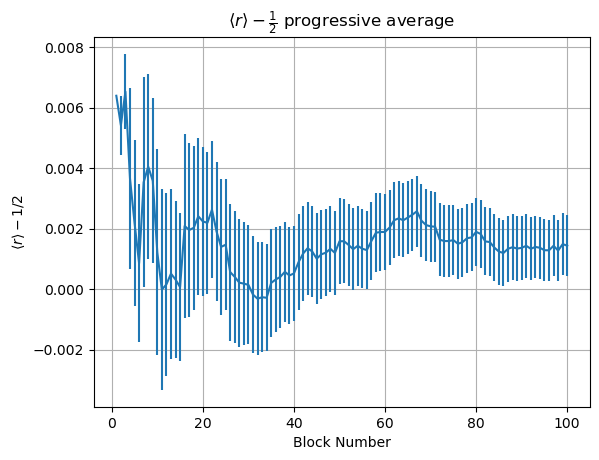

Final avg.: 0.00143761
Error: 0.00101189


In [11]:
avg_prog, error_prog = np.loadtxt(csv_path + "Ex1_1_1.csv", delimiter=',', usecols=(0, 1), unpack=True)

M = 10000
N = 100

L = M / N

x = np.arange(N) + 1

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('Block Number')
plt.ylabel(r'$\langle r \rangle -1/2$')
plt.title(r'$\langle r \rangle - \frac{1}{2}$ progressive average')
plt.grid(True)
plt.show()

print("Final avg.: {}\nError: {}".format(avg_prog[-1], error_prog[-1]))

It is clear that $\langle r \rangle$ correctly converges to the expected value $\frac{1}{2}$ (or equivalently $\langle r \rangle - \frac{1}{2}$ converges to $0$, as in the previous plot), within slightly more than 1 standard deviation. Furthermore, the statistical error decrease as the number of blocks increases, exactly as expected.

## 1.1.2

We will now compute the integral $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$, which corresponds to the standard deviation of the mean ($\langle r \rangle$) for the observable $r$. We will use again the data-blocking technique, with the same parameters as the previous exercise.

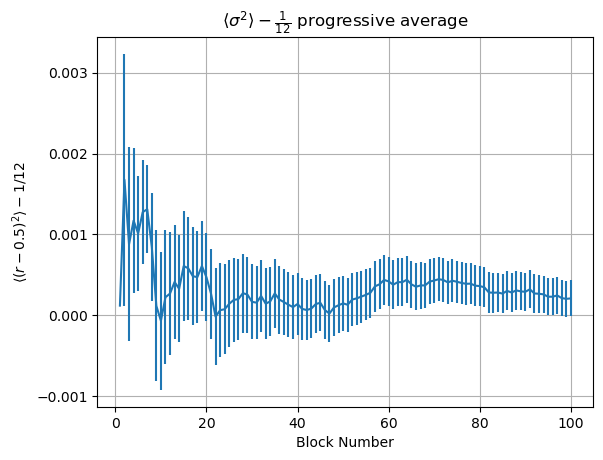

Final avg.: 0.000207252
Error: 0.000222892


In [14]:
avg_prog, error_prog = np.loadtxt(csv_path + "Ex1_1_2.csv", delimiter=',', usecols=(0, 1), unpack=True)

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('Block Number')
plt.ylabel(r'$\langle(r-0.5)^2\rangle-1/12$')
plt.title(r'$\langle \sigma^2 \rangle - \frac{1}{12}$ progressive average')
plt.grid(True)
plt.show()

print("Final avg.: {}\nError: {}".format(avg_prog[-1], error_prog[-1]))

As in the previuos exercise, the final average $\sigma^2$ is compatible with the expected value $\frac{1}{12}$ (or equivalently I can say that $\sigma^2 - \frac{1}{12}$ converges to zero), in this case within one standard deviation.

## 1.1.3

In order to test whether the pseudo-casually generated random numbers correctly approximate a true random number generator, we will perform a $\chi^2$ test, following this procedure:

1. The sampling interval $[0,1)$ is divided into $M = 100$ identical sub-intervals
2. An histogram is filled with the number of randomly generated numbers out of $10^4$ throws that fall in each sub-interval.
3. $\chi^2$ is computed using the formula: $\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$, where $n_i$ is the count for the i-th bin.

This procedure is iterated $100$ times, and in each iteration the previusly obtained count histogram is updated. In such a way $100$ values of $\chi^2$ are obtained and they can be grouped into an histogram showing the counts for each obtained value of $\chi^2$. We can then evaluate the results comparing the $\chi^2$ values with the theroretical expectetion $\chi^2=100$.

In [82]:
def param_chi(x, k):
    
    return ss.chi2.pdf(x, df=k)

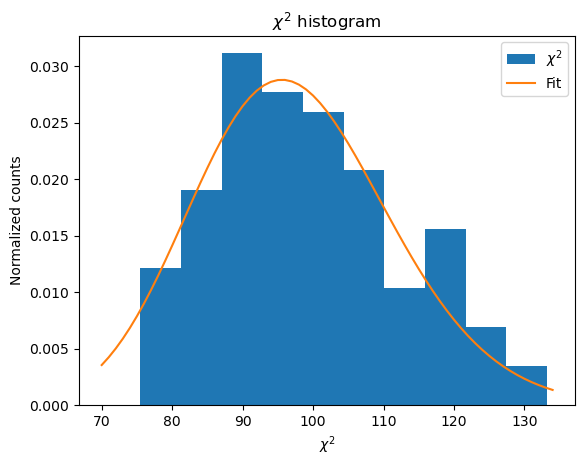

Fit DOFs: 97.57278072472707	Error: 1.1242789406485199


In [84]:
idx, chi = np.loadtxt(csv_path + "Ex1_1_3.csv", delimiter=',', usecols=(0, 1), unpack=True)
chi_x=np.arange(70, 135, 1)
counts, bins = np.histogram(chi, density = True)

bins_fit = bins[:-1] + (bins[1] - bins[0]) / 2
popt, pcov = so.curve_fit(param_chi, bins_fit, counts, p0 = (100.))
pstddev = np.sqrt(np.diag(pcov))

plt.hist(bins[:-1], bins, weights=counts, label = r'$\chi^2$')
plt.plot(chi_x, ss.chi2.pdf(chi_x, df = popt[0]), label = "Fit")
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'Normalized counts')
plt.title(r'$\chi^2$ histogram')
plt.legend()
plt.show()

print("Fit DOFs: {}\tError: {}".format(popt[0], pstddev[0]))

The obtained $\chi^2$ value are indeed compatible with a theoretical $\chi^2$ distribution with $100$ degrees of freedom. This is shown, besides the qualitative compatibility betweern the $\chi^2$ histogram and a general $\chi^2$ pdf, by the compatibility between the expected DOF ($100$) and the DOF value obtained by fit within $3$ standard deviations.

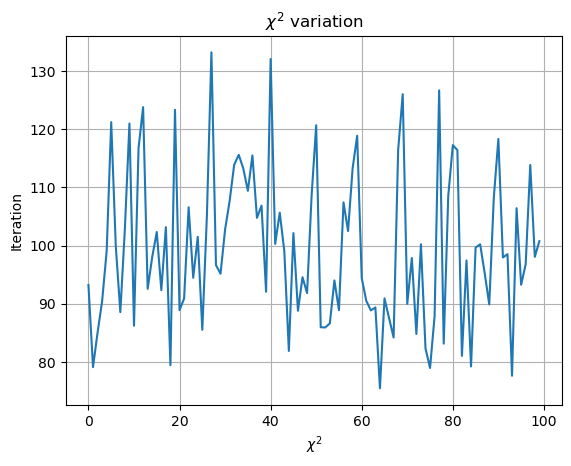

Average Chi2: 99.5756
Chi2 variance: 175.91599664
Chi2 std. dev: 13.26333278780262


In [80]:
plt.plot(idx, chi)
plt.xlabel(r'$\chi^2$')
plt.ylabel("Iteration")
plt.title(r'$\chi^2$ variation')
plt.grid(True)
plt.show()

print("Average Chi2: {}\nChi2 variance: {}\nChi2 std. dev: {}".format(np.average(chi), np.var(chi), np.std(chi)))

Furthermore, if we look at bare $\chi^2$ value for each iteration we can see that the average $\chi^2$ is very close to the theoretical value, and the same applies for its variance and standard deviation (the theoretical variance and standard deviation for the $\chi^2$ pdf are given by $2 M$ and $\sqrt{2M}$, with M beinf the DOF number). We can than say that the utilized pseudo-random number generator indeed acts as a good approximation of true real number generator.

# Exercise 1.2

In this exercise we will test the Central Limit Theorem (CLT) with three different distribution: 
1. Uniform
2. Exponential
3. Cauchy-Lorentz.

To do this the observable $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (with $x_i$ being a random variable distributed according to the desired distribution) will be evaluated $10^4$ times for $N\in{\{1,2,10,100\}}$; the obtained value will then be used to fill an histogram, which will be graphe dfor each value of $N$. On the histogram with $N = 100$ I am going to perform a fit against the distribution attractor (gaussian in the first two cases, Cauchy-Lorentz in the third).

In [106]:
def param_gauss(x, m, s): 

    return ss.norm.pdf(x, loc = m, scale = s)

def param_cl(x, m, g):

    return ss.cauchy.pdf(x, m, g)

Mu: 0.49971451473661765	Error: 0.00024817304261077436
Sigma: 0.028519273524817763	Error: 0.00020264077451777985


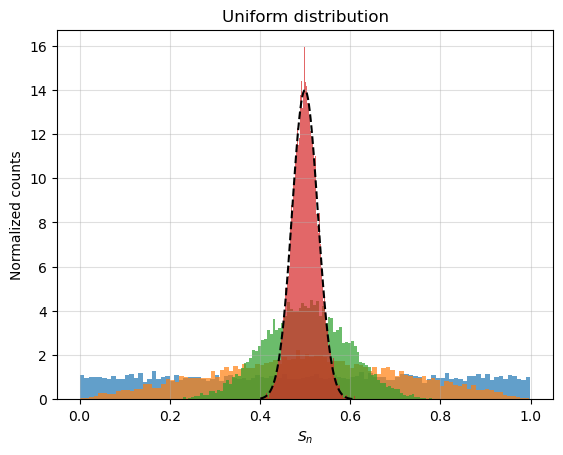

In [135]:
lin_data = np.loadtxt(csv_path + "Ex1_2_lin.csv", delimiter=',')

for i in range(0, 4):

    counts, bins = np.histogram(lin_data[:,i], 100, density=True)
    plt.hist(bins[:-1], bins, weights = counts, alpha = 0.7)

    if i == 3:

        bins_fit = bins[:-1] + (bins[1] - bins[0]) / 2
        popt, pcov = so.curve_fit(param_gauss, bins_fit, counts)
        pstd = np.sqrt(np.diag(pcov))

        x_fit = np.linspace(bins[0], bins[-1], 100)
        plt.plot(x_fit, param_gauss(x_fit, popt[0], popt[1]), color = 'black', linestyle = '--')

        print("Mu: {}\tError: {}".format(popt[0], pstd[0]))
        print("Sigma: {}\tError: {}".format(popt[1], pstd[1]))

plt.xlabel(r"$S_n$")
plt.ylabel("Normalized counts")
plt.title("Uniform distribution")
plt.grid(alpha = 0.4)
plt.show()

Mu: 0.9957766161255747	Error: 0.0009245708439373064
Sigma: 0.09902294933707562	Error: 0.0007550008252610066


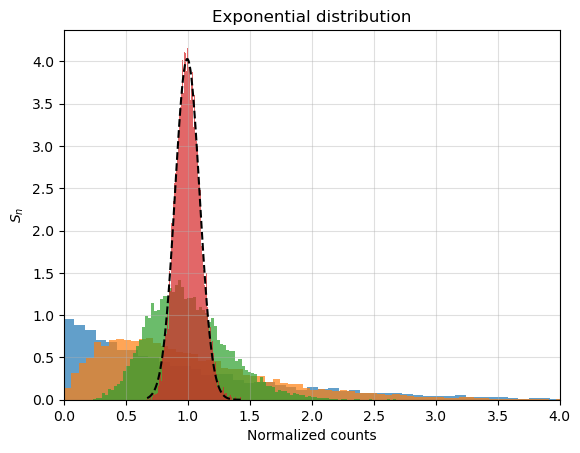

In [134]:
exp_data = np.loadtxt(csv_path + "Ex1_2_exp.csv", delimiter=',')

for i in range(0, 4):

    counts, bins = np.histogram(exp_data[:,i], 100, density=True)
    plt.hist(bins[:-1], bins, weights = counts, alpha = 0.7)

    if i == 3:

        bins_fit = bins[:-1] + (bins[1] - bins[0]) / 2
        popt, pcov = so.curve_fit(param_gauss, bins_fit, counts)
        pstd = np.sqrt(np.diag(pcov))

        x_fit = np.linspace(bins[0], bins[-1], 100)
        plt.plot(x_fit, param_gauss(x_fit, popt[0], popt[1]), color = 'black', linestyle = '--')

        print("Mu: {}\tError: {}".format(popt[0], pstd[0]))
        print("Sigma: {}\tError: {}".format(popt[1], pstd[1]))

plt.xlim(right = 4, left = 0)
plt.xlabel(r"$S_n$")
plt.ylabel("Normalized counts")
plt.title("Exponential distribution")
plt.grid(alpha = 0.4)
plt.show()

Mu: -0.0076679153498369155	Error: 0.010514722755423483
Gamma: 0.9226797417254768	Error: 0.010518053654107925


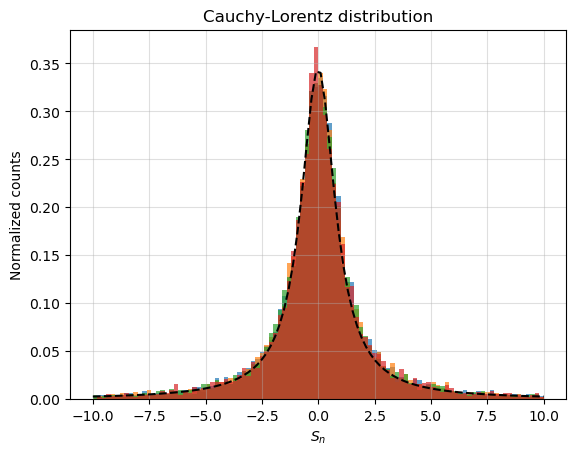

In [137]:
cl_data = np.loadtxt(csv_path + "Ex1_2_cl.csv", delimiter=',')

for i in range(0, 4):

    counts, bins = np.histogram(cl_data[:,i], 100, [-10, 10], density=True)
    plt.hist(bins[:-1], bins, weights = counts, alpha = 0.7)

    if i == 3:

        bins_fit = bins[:-1] + (bins[1] - bins[0]) / 2
        popt, pcov = so.curve_fit(param_cl, bins_fit, counts)
        pstd = np.sqrt(np.diag(pcov))

        x_fit = np.linspace(bins[0], bins[-1], 100)
        plt.plot(x_fit, param_cl(x_fit, popt[0], popt[1]), color = 'black', linestyle = '--')

        print("Mu: {}\tError: {}".format(popt[0], pstd[0]))
        print("Gamma: {}\tError: {}".format(popt[1], pstd[1]))

plt.grid(alpha = 0.4)
plt.xlabel(r"$S_n$")
plt.ylabel("Normalized counts")
plt.title("Cauchy-Lorentz distribution")
plt.show()

It is immediate to see that the observable $S_n$ for the uniform and exponential distribution converges to a Gaussian ditribution, while for the Cauchy-Lorentz distribution it converges to a Cauchy-Lorentz distribution (note that in this case for all variable of $N$ the histogram represents a Cauchy-Lorentz distribution). The obtained results are then compatible with the CLT.

# Exercise 1.3

In this exercise I am going to evaluate $\pi$ simulating the Buffon experiment: by throwing a needle of length $L$ onto a grid of lines sperated by a distance $d$ (with $d>L$), $pi$ can be estimated with the following formula: $$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$
The needle will be thrown $10^5$ times, grouped into $100$ so as to use the data-blocking technique. In each block I will compute the number of times $N_{Hit}$ in which the needle (randomly oriented) intersects a line, and then use this to compute $\pi$ in each block.


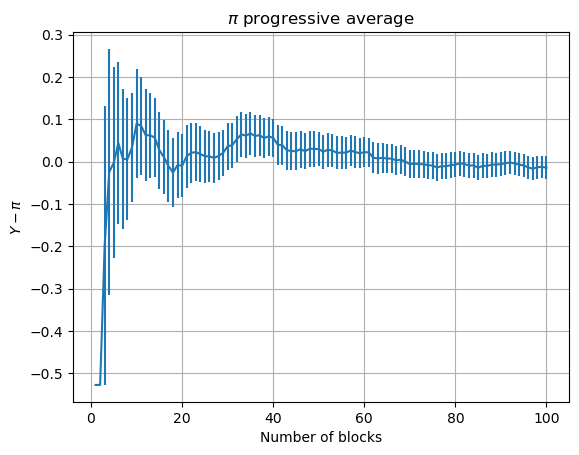

Average Pi value: 3.1438588
Final Pi value: 3.12737	Error: 0.0265935


In [142]:
pi_data = np.loadtxt(csv_path + "Ex1_3.csv", delimiter=',')
x = np.arange(1, 101, 1)

plt.errorbar(x,pi_data[:,0] - math.pi,yerr=pi_data[:,1])
plt.xlabel('Number of blocks')
plt.ylabel(r'$Y - \pi$')
plt.title(r'$\pi$ progressive average')
plt.grid(True)
plt.show()

print("Average Pi value: {}".format(np.average(pi_data[:,0])))
print("Final Pi value: {}\tError: {}".format(pi_data[-1,0], pi_data[-1,1]))


As we can see from the previous graph, with the described method we can obtain an accurate estimate of $\pi$ (within one standard deviation). As an additional note, to sample the needle position I had to generate pseudo-random points on a circumference, so as to calculate one needle vertex position. This can be easily done generating a uniform number between 0 and $\pi$ (i.e. the needle rotation angle), but, since we do not know $\pi$ a priori, a different method is required (accept-reject). To check whether this method do generate uniform points on a unitary circumference, I dumped a couple of generated points and graphed them below. 

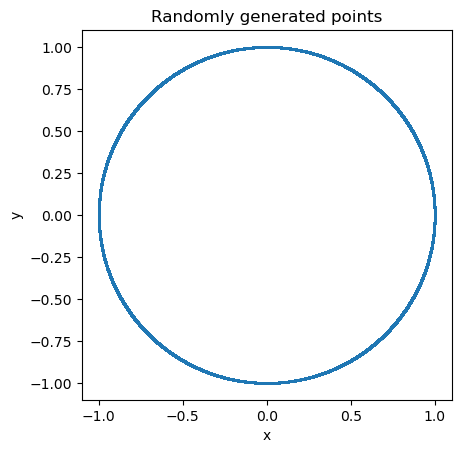

In [147]:
pos_data = np.loadtxt(csv_path + "Ex1_3_pos.csv", delimiter=',')

plt.scatter(pos_data[:,0], pos_data[:,1], s = 1)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Randomly generated points")
plt.show()